In [193]:
import os
from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import librosa
import torch
import matplotlib
import matplotlib.pyplot as plt
import random
import IPython.display as ipd

matplotlib.use('Agg')

%matplotlib inline

from matplotlib.colors import Normalize
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from argparse import ArgumentParser
from omegaconf import OmegaConf
from unicodedata import normalize

#from utils.utils import get_commit_hash
from tacotron import Tacotron
from datasets import TextMelDataset, text_mel_collate
from datasets.text import Language
from datasets.text.symbols import kor_symbols
from rule_based_G2P import process
from rule_based_G2P import hangeul
from modules.mel import Audio2Mel
#from utils.plots import plot_spectrogram

def get_text(text):
    stoi = { s : i for i,s in enumerate(kor_symbols)}
    text_norm = [80]
    for t in text:
        chk = 0

        if t > 5000:
            t = t - 1000

            text_norm.append(stoi[chr(t)])
        else:
            text_norm.append(stoi[chr(t)])
    text_norm.append(1)
    text_norm = torch.LongTensor(text_norm)
    
    return text_norm

if __name__ == '__main__':
    parser = ArgumentParser()
    parser.add_argument('-c', '--config', type=str, required=True,
                        help="path of configuration yaml file")
    parser.add_argument('-g', '--gpus', type=str, default=None,
        help="Number of gpus to use (e.g. '0,1,2,3'). Will use all if not given.")
    parser.add_argument('-n', '--name', type=str, required=True,
                        help="Name of the run.")
    parser.add_argument('-p', '--checkpoint_path', type=str, default=None,
                        help="path of checkpoint for resuming")
    parser.add_argument('-s', '--save_top_k', type=int, default=-1,
                        help="save top k checkpoints, default(-1): save all")
    parser.add_argument('-f', '--fast_dev_run', type=bool, default=False,
                        help="fast run for debugging purpose")
    parser.add_argument('--val_epoch', type=int, default=1,
                        help="run val loop every * training epochs")
    lu=['-c','config/config.yaml','-n','trash','-p']
    
    lu.append('/raid/kwkim/mellotron/chkpt/ver_2/8030c1bepoch=64.ckpt')
    
    args = parser.parse_args(lu)
    
    #hp = OmegaConf.load(args.config)

    net=Tacotron.load_from_checkpoint(args.checkpoint_path).cuda().eval()
    net.freeze()
    
    hp =net.hp
    
    if torch.cuda.is_available():
        device = torch.device("cuda")



In [194]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

In [195]:
stft = Audio2Mel(
            n_fft=hp.audio.filter_length, hop_length=hp.audio.hop_length,
            win_length=hp.audio.win_length, sampling_rate=hp.audio.sampling_rate,
            n_mel_channels=hp.audio.n_mel_channels,
            mel_fmin=hp.audio.mel_fmin, mel_fmax=hp.audio.mel_fmax)

## Setup dataloaders

In [196]:
dataloader = TextMelDataset(hp, 'data','examples_filelist.txt',train=False)
collate_fn = text_mel_collate(hp.train.n_frames_per_step)

## Load data

In [266]:
file_idx = 0
audio_path, _,_ = dataloader.meta[file_idx]
x = dataloader.__getitem__(file_idx)

batch = collate_fn([x])

# get audio path, encoded text, pitch contour and mel for gst

In [267]:
x, sr = librosa.load(os.path.join('data',audio_path))
ipd.Audio(x, rate=hp.audio.sampling_rate)

## Define Speakers Set

In [268]:
speaker_list = list(hp.data.speakers)
print(speaker_list)

['kss', 'KVA_W', 'KVA_M', 'lec01', 'ma', 'fa', 'SDS', 'agent', 'care', 'president', 'soojin', 'CWWFEMALE', 'CWWMALE', 'YJH', 'JIS', 'KSH', 'KANE', 'KDH']


In [269]:
with open('result.txt', 'r', encoding='utf-8') as g:
    pitches = g.readlines()
speaker_list_2 = [x.split('|')[0].strip() for x in pitches]
mins = [float(x.split('|')[1].strip()) for x in pitches]
maxs = [float(x.split('|')[2].strip()) for x in pitches]
means = [float(x.split('|')[3].strip()) for x in pitches]
if(speaker_list == speaker_list_2):
    print('ok')

ok


# Style Transfer (Rhythm and Pitch Contour)

In [303]:
with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    text, mel_target, speakers, f0s, input_lengths, output_lengths, max_input_len = batch
    text=text.cuda()
    mel_target = mel_target.cuda()
    speakers = speakers.cuda()
    f0s = f0s.cuda()
    input_lengths = input_lengths.cuda()
    output_lengths = output_lengths.cuda()
    max_input_len = max_input_len.cuda()
    _, _, rhythm = net.forward(text, mel_target, speakers, f0s, input_lengths, output_lengths, max_input_len)
    rhythm = rhythm.permute(1, 0, 2)
    print(text)

tensor([[80, 14, 25, 79, 13, 41, 45,  2, 21,  4, 41, 79,  8, 35, 49, 79, 20, 21,
          5, 39, 45,  2, 21,  4, 26, 73, 79, 13, 21, 45,  8, 21, 49,  7, 27, 73,
         79,  4, 22,  2, 21, 79, 13, 21, 45, 79,  8, 21, 49,  7, 27, 79, 14, 25,
         49,  6, 22, 75,  1]], device='cuda:0')


JIS


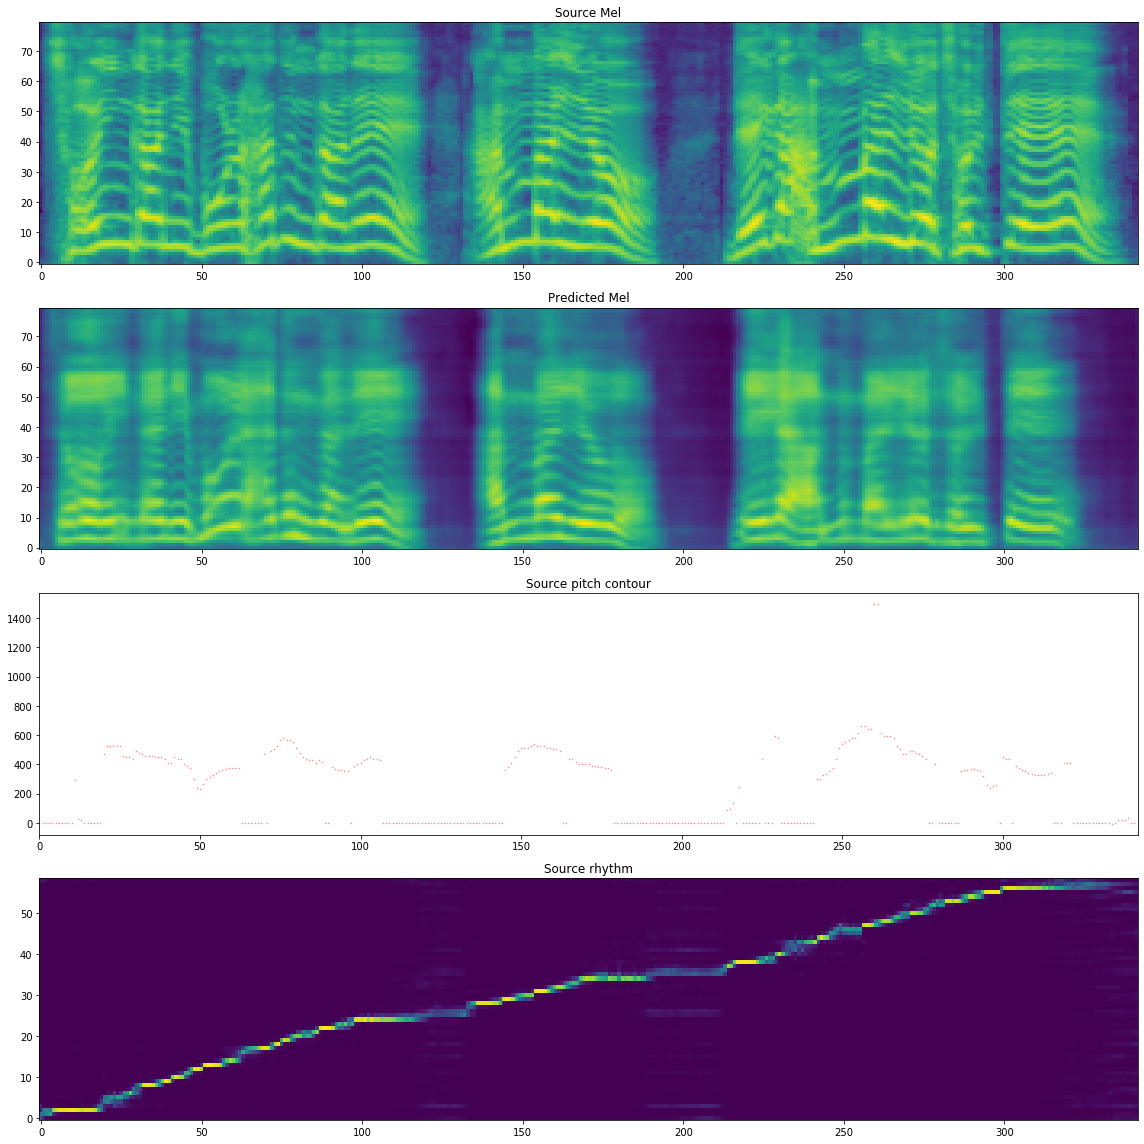

In [304]:
speaker_id = random.randrange(len(speaker_list))
print(speaker_list[speaker_id])
#speaker_id = 3
i = speakers.cpu()[0]

f0s = f0s.cpu().numpy()
mask = f0s != 0.0

f0s[mask] -= means[i]
f0s[mask] /= maxs[i]-mins[i]
f0s[mask] *= maxs[speaker_id]-mins[speaker_id]
f0s[mask] += means[speaker_id]

f0s = torch.FloatTensor(f0s).cuda()
speaker_id = torch.LongTensor([speaker_id]).cuda()

with torch.no_grad():
    mel_outputs_postnet, alignment = net.inference_noattention(
        text, mel_target, speaker_id, f0s, rhythm)
alignment = alignment.permute(1,0,2)
plot_mel_f0_alignment(mel_target.data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      f0s.data.cpu().numpy()[0, 0],
                      alignment.data.cpu().numpy()[:, 0].T)

In [305]:
savepath="output/g2p_testmodel.mel"
    
torch.save(mel_outputs_postnet, savepath)

# Singing Voice from Music Score

In [92]:
data = get_data_from_musicxml('data/haendel_hallelujah.musicxml', 132, convert_stress=True)
panning = {'Soprano': [-60, -30], 'Alto': [-40, -10], 'Tenor': [30, 60], 'Bass': [10, 40]}

NameError: name 'get_data_from_musicxml' is not defined

In [ ]:
n_speakers_per_part = 4
frequency_scaling = 0.4
n_seconds = 90
audio_stereo = np.zeros((hparams.sampling_rate*n_seconds, 2), dtype=np.float32)
for i, (part, v) in enumerate(data.items()):
    rhythm = data[part]['rhythm'].cuda()
    pitch_contour = data[part]['pitch_contour'].cuda()
    text_encoded = data[part]['text_encoded'].cuda()
    
    for k in range(n_speakers_per_part):
        pan = np.random.randint(panning[part][0], panning[part][1])
        if any(x in part.lower() for x in ('soprano', 'alto', 'female')):
            speaker_id = torch.LongTensor([next(female_speakers)]).cuda()
        else:
            speaker_id = torch.LongTensor([next(male_speakers)]).cuda()
        print("{} MellotronID {} pan {}".format(part, speaker_id.item(), pan))

        with torch.no_grad():
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments_transfer = mellotron.inference_noattention(
                (text_encoded, mel, speaker_id, pitch_contour*frequency_scaling, rhythm))

            audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[0, 0]
            audio = audio.cpu().numpy()
            audio = panner(audio, pan)
            audio_stereo[:audio.shape[0]] += audio            
            write("{} {}.wav".format(part, speaker_id.item()), hparams.sampling_rate, audio)

In [ ]:
audio_stereo = audio_stereo / np.max(np.abs(audio_stereo))
write("audio_stereo.wav", hparams.sampling_rate, audio_stereo)
ipd.Audio([audio_stereo[:,0], audio_stereo[:,1]], rate=hparams.sampling_rate)